Instructions: Run all of the cells in this notebook from the "Setup" and "Load Precomputed Data" sections. Then, find your name in the "Model Playground" section and play around with it. Read the documentation about the model you are using, and if you feel ambitious, try to find other examples in the literature. Take some time to understand all of the parameters available to your model and try to quantify the effects of each. For example, some parameters affect the speed of computation while others should be set only under certain circumstances. Others will tune the model on the bias-variance scale trading off accuracy for genericity. Feel free to take notes under your section and commit them back to the repo. This should be considered a living document that we all can gain insight from.

As a bare minimum see if you can answer the following questions regarding your assigned model:

* Give a brief description of how your model works.
* What are the hyperparameters for your model?
* How did you tune them, and what worked best?
* How many relevant dimensions were needed to compute your data?
* What were the most relevant predictors?

# Setup

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble, svm, model_selection, neighbors, linear_model, gaussian_process, neural_network, naive_bayes, tree
from read_msc import *
import time
import pickle

## Pretty Colors

In [2]:
light_red = '#fbb4ae'
red = '#e41a1c'

light_blue = '#b3cde3'
blue = '#377eb8'

light_green = '#ccebc5'
green = '#4daf4a'

light_purple = '#decbe4'
purple = '#984ea3'

light_orange = '#fed9a6'
orange = '#ff7f00'

light_palette = [light_red, light_blue, light_green, light_purple, light_orange]
bold_palette = [red, blue, green, purple, orange]

## Reusable Variables and Functions

In [3]:
def show_image(image):
    plt.figure(num=None, dpi=200)
    plt.imshow(image, cmap=plt.cm.Greys_r)
    plt.axis('off')

def show_training_samples(image, in_samples, out_samples):
    show_image(image)
    plt.scatter(in_samples[:, 0], in_samples[:, 1], color=orange, s=1, marker=',')
    plt.scatter(out_samples[:, 0], out_samples[:, 1], color=purple, s=1, marker=',')

def show_classifier_result(compiled_data, classifier):
    flattened_data = compiled_data.reshape(-1, compiled_data.shape[-1])
    predicted_labels = classifier.predict(flattened_data)
    predicted_labels = predicted_labels.reshape(compiled_data.shape[0], compiled_data.shape[1])
    show_image(predicted_labels)

# Load Precomputed Data

## Load Image and Filters

In [4]:
fname_base = 'max_diadem_smoothed'
compiled_data = np.load(fname_base + '_input.npy')

with open(fname_base + '_dimensions.txt', 'r') as f:
    dimensions = [line.strip() for line in f]

## Load Morse-Smale Complex

In [5]:
fname_raw = fname_base + ".raw"
test_msc_coarse = MSC()
test_msc_coarse.read_from_file(fname_raw)

## Load Training Data

In [6]:
in_samples = np.loadtxt(fname_base + '_in_samples.txt', dtype=int)
out_samples = np.loadtxt(fname_base + '_out_samples.txt', dtype=int)

In [7]:
in_class = compiled_data[in_samples[:, 1], in_samples[:, 0], :]
out_class = compiled_data[out_samples[:, 1], out_samples[:, 0], :]
train_x = np.vstack((in_class, out_class))
train_y = np.hstack((np.ones(in_class.shape[0]), np.zeros(out_class.shape[0])))

## Visually Verify Everything Loaded Properly

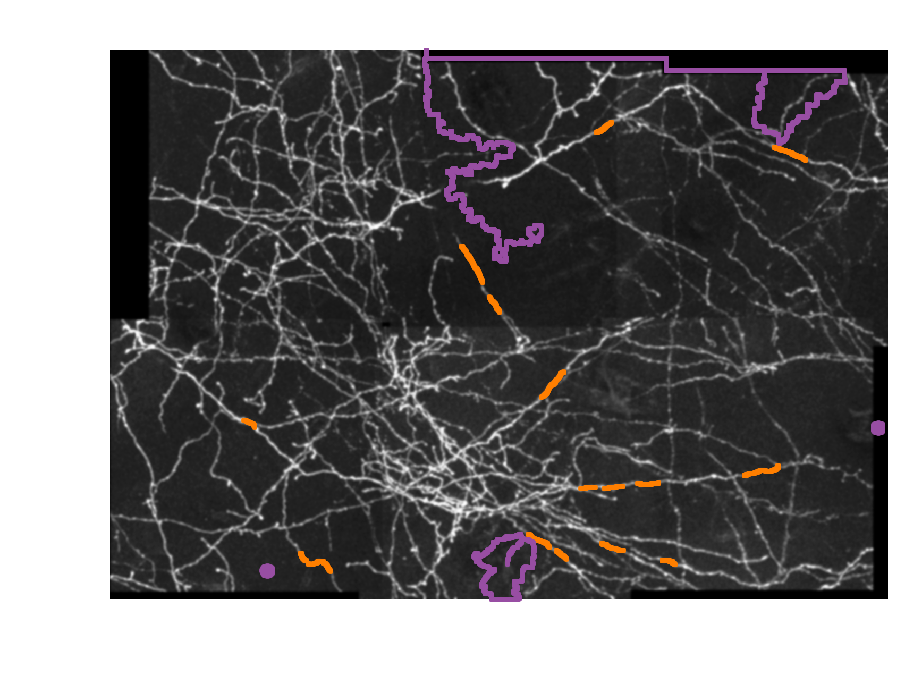

In [40]:
show_training_samples(compiled_data[:,:,0], in_samples, out_samples)

# Model Playground

## Example Analysis

I will start with a generic example using _logistic regression_, if you are lacking creativity/time you could replicate this analysis exactly only swapping out the relevant information of your model.

### Logistic Regression

Aliases:
* Logit regression
* Maximum-entropy classification (MaxEnt)
* Log-linear classifier

We model the probability of a binary outcome (0 or 1) for a given input using a logistic function:

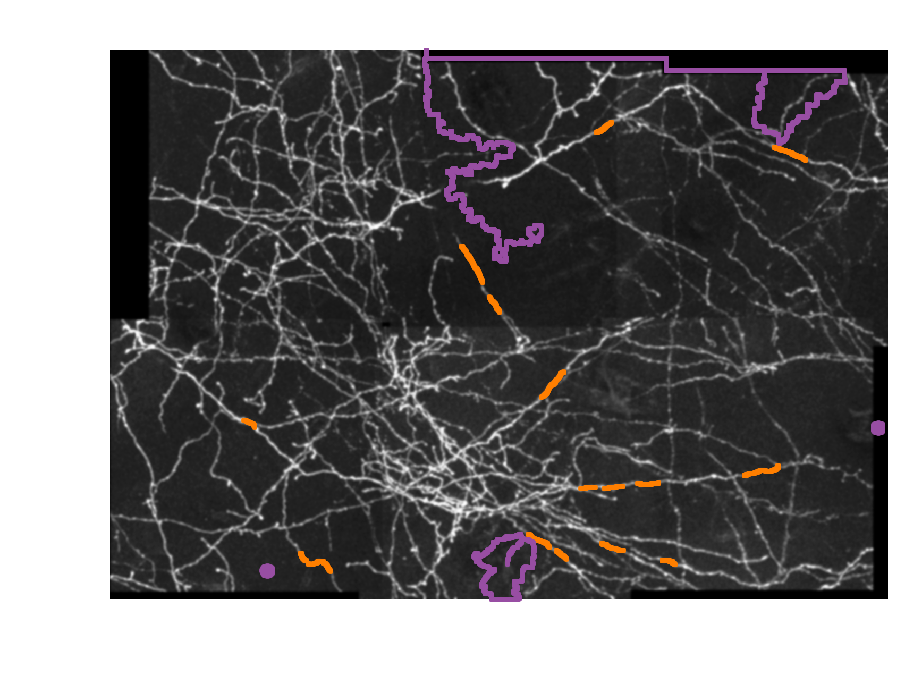

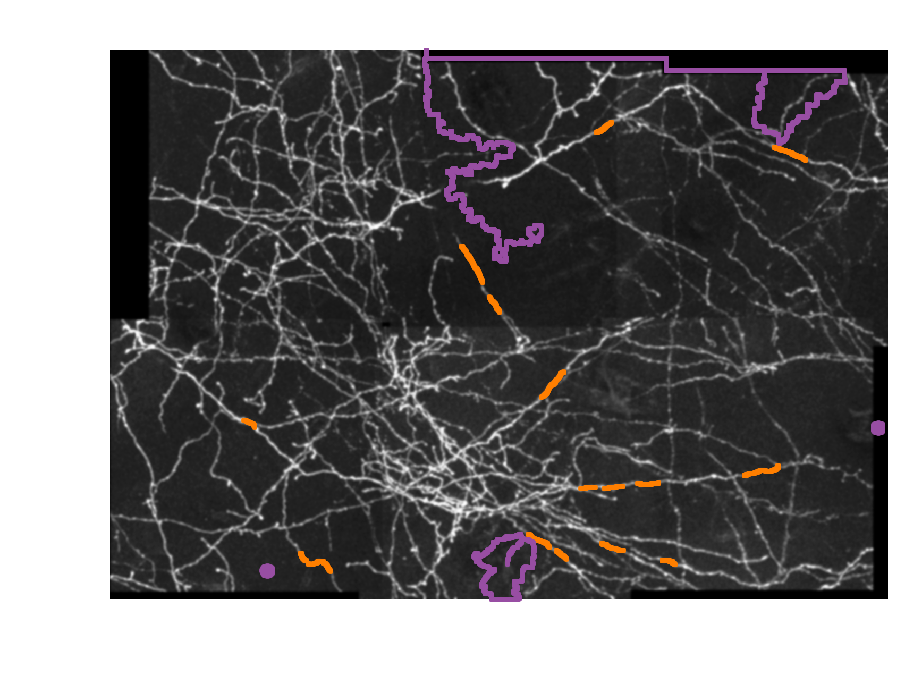

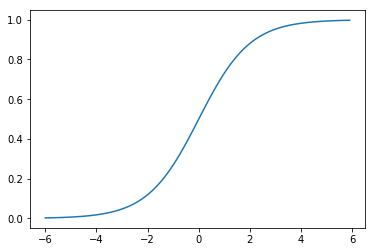

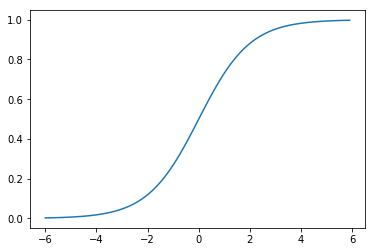

In [11]:
def logistic(x):
    L = 1   # maximum value
    k = 1   # steepness
    x0 = 0  # midpoint
    return L / (1 + np.exp(-k*(x-x0)))

plt.figure()
x = np.arange(-6, 6, 0.1)
plt.plot(x, logistic(x))
plt.show()

#### Optimization Problem:

* _$L_2$_ Penalized Logistic Regression:

$$\min_{w,c}\frac{1}{2}w^Tw + C\sum_{i=1}^{n}\log(e^{-y_i(X_i^Tw + c)} + 1)$$

* _$L_1$_ Penalized Logistic Regression:

$$\min_{w,c}||w||_1 + C\sum_{i=1}^{n}\log(e^{-y_i(X_i^Tw + c)} + 1)$$


#### Parameters

* `penalty` - see above. The $L_1$ penalty can only be used with the following parameters:
  * dual=False
  * solver={'liblinear', 'saga'}
* `dual` - set to False when you have more samples than dimensions (arguably the typical case for us)
* `C` - penalty factor. Shifts answer on bias-variance trade-off scale. Larger values favor ovefitting a model whil smaller favor 
* `fit_intercept` - An extra parameter than needs fitted.
* `intercept_scaling` - TODO
* `solver` - There are a bunch of different available implementations with their own trade-offs. I explore these in the context of our problem in a later cell.

stopping criteria:
 * `tol`
 * `max_iter`
 
performance:
 * `n_jobs` - Use -1 for best performance, though it won't matter if the solver is liblinear.
 * `warm_start` - shouldn't matter as we are not typically retraining our model, otherwise uses the last fit as the initialization for the next call to fit
 
misc:
 * `random_state` - a few of the solvers utilize random shuffling of the data, this ensures reproducibility
 * `class_weight` - potentially useful if you have a class imbalance problem
 * `verbose` - we can probably keep this off
 * `multi_class` - Don't worry about this one, for now we are focusing only on binary classification.

#### Tuning

{'C': 10, 'penalty': 'l2'} 0.990889074482


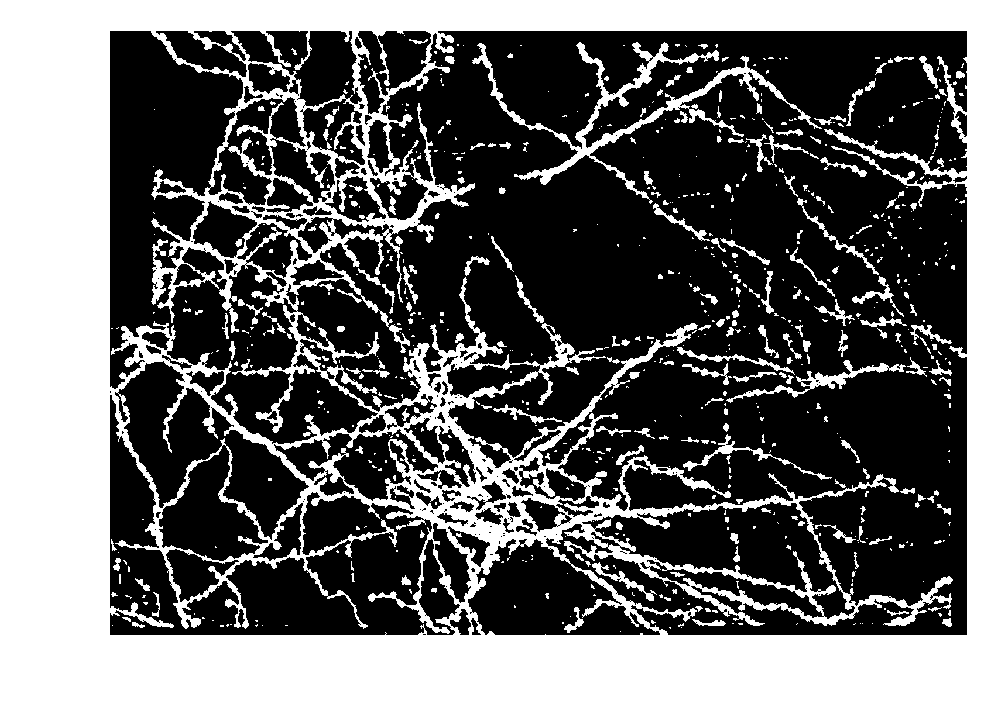

In [21]:
logit = linear_model.LogisticRegression(penalty='l2',
                                        dual=False,
                                        tol=0.0001,
                                        C=1.0,
                                        fit_intercept=True,
                                        intercept_scaling=1,
                                        class_weight=None,
                                        random_state=None,
                                        solver='liblinear',
                                        max_iter=100,
                                        verbose=0,
                                        warm_start=False,
                                        n_jobs=1)
logit.fit(train_x, train_y)
logit.score(train_x, train_y)

param_grid = {'penalty': ['l1', 'l2'],
              'C': [1.0, 10],}

best_logit = model_selection.GridSearchCV(logit, param_grid)
best_logit.fit(train_x, train_y)
print(best_logit.best_params_, best_logit.best_score_)
show_classifier_result(compiled_data, best_logit)

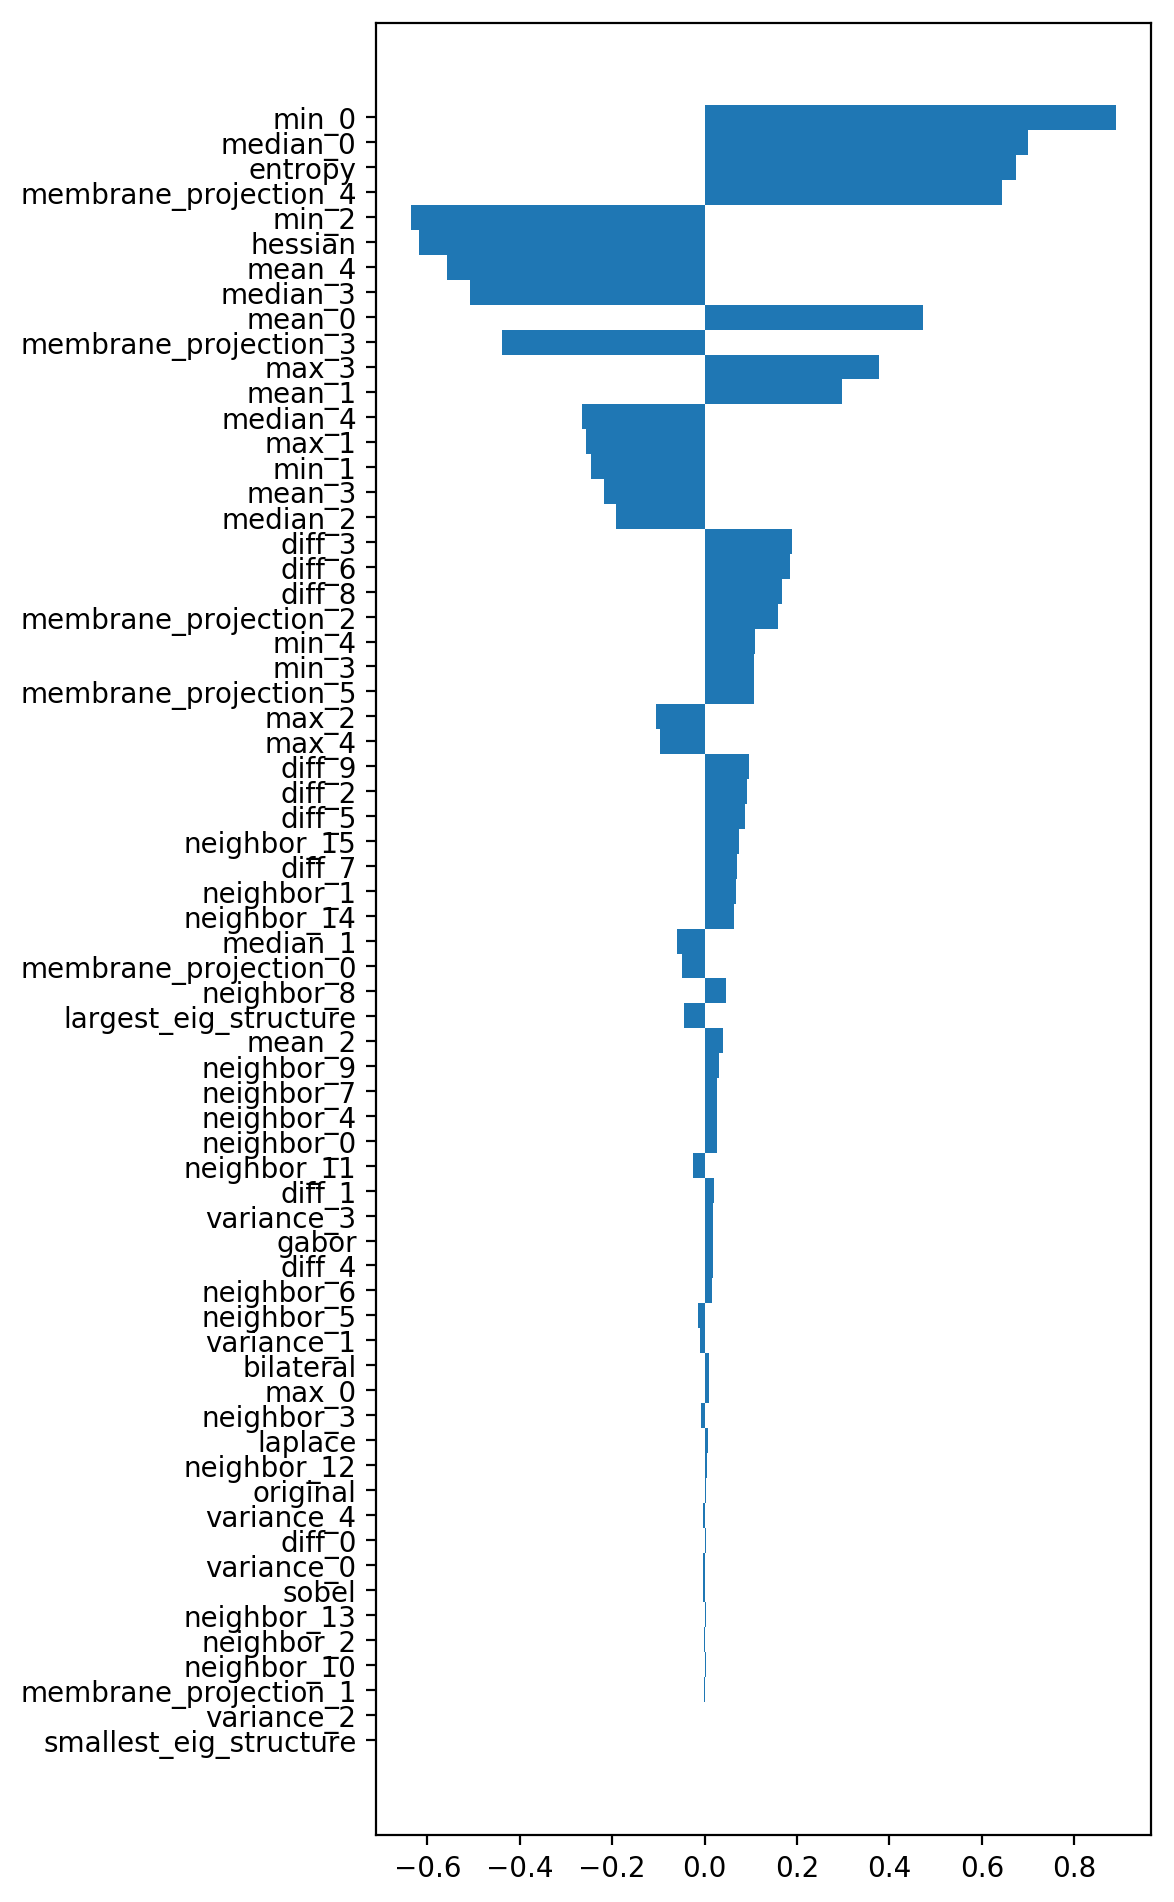

In [13]:
logit = best_logit.best_estimator_
coefs = logit.coef_[0]
sorted_indices = np.argsort(np.abs(coefs))
dimensions = np.array(dimensions)
plt.figure(dpi=200, figsize=(5,12))
_ = plt.barh(y=np.arange(0, 1*len(dimensions), 1), width=coefs[sorted_indices], align='center', height=1.0, tick_label=dimensions[sorted_indices])

Okay, I like this model, let's pickle it for use later.

In [16]:
f = open('logit.pk', 'wb')
pickle.dump(logit, f)
f.close()

Try again with only the top 10 performing filters and also try out the different solvers:

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


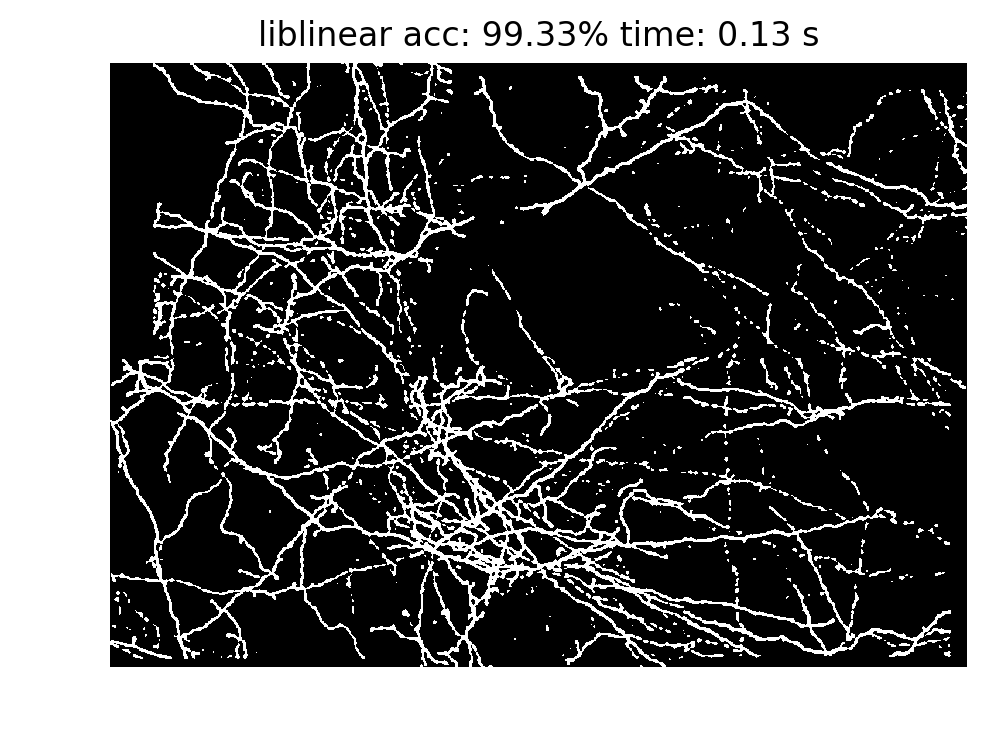

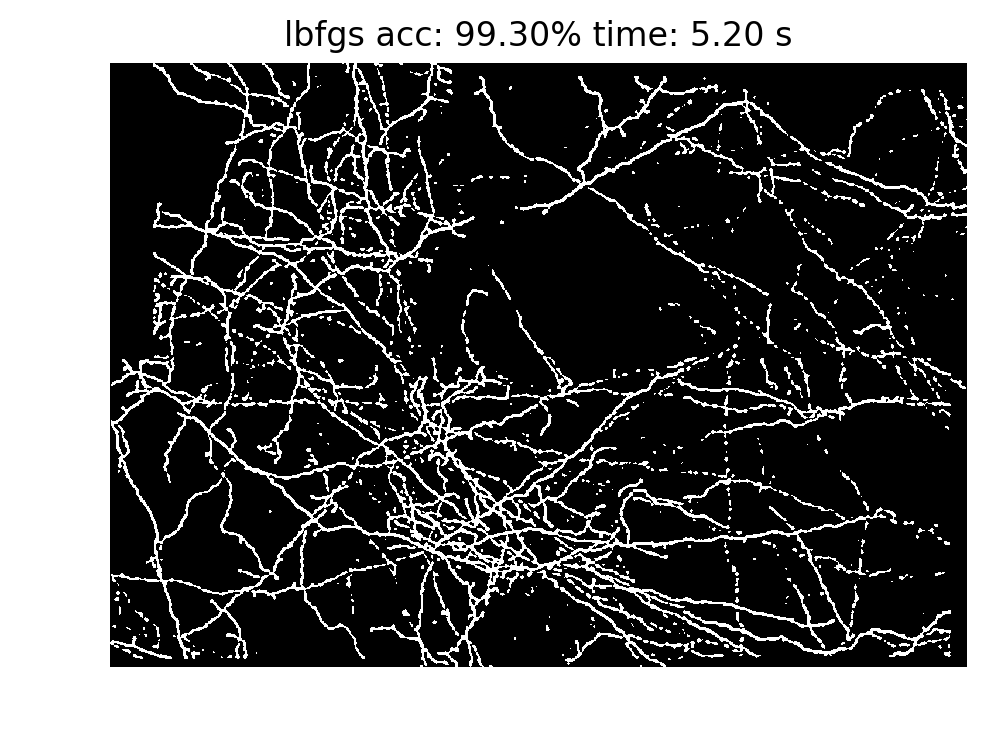

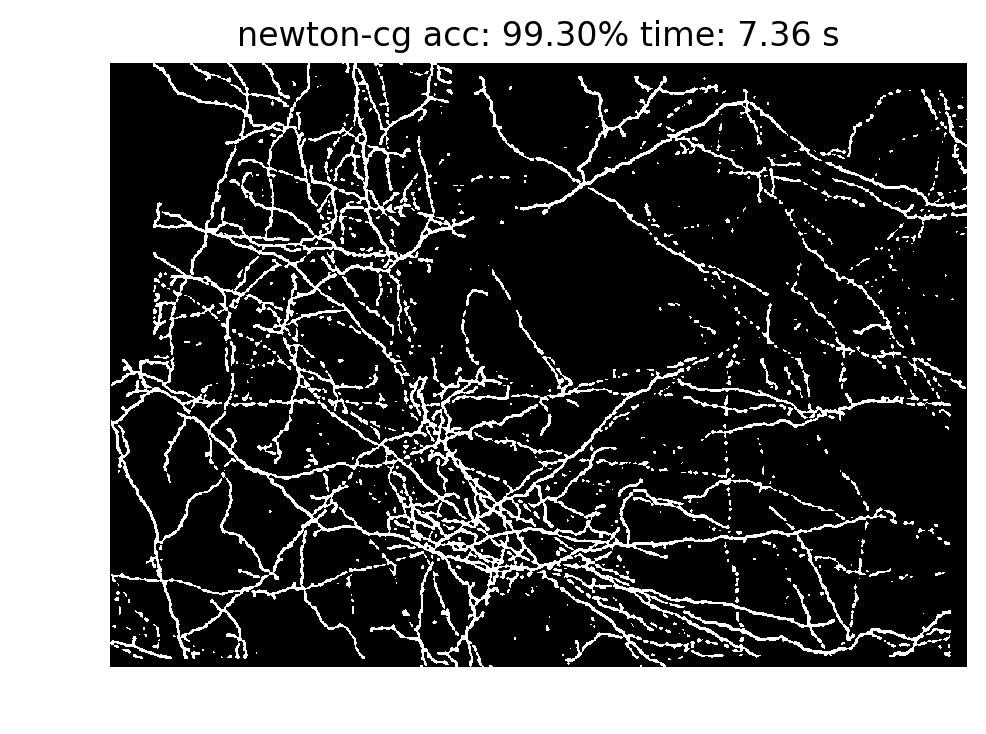

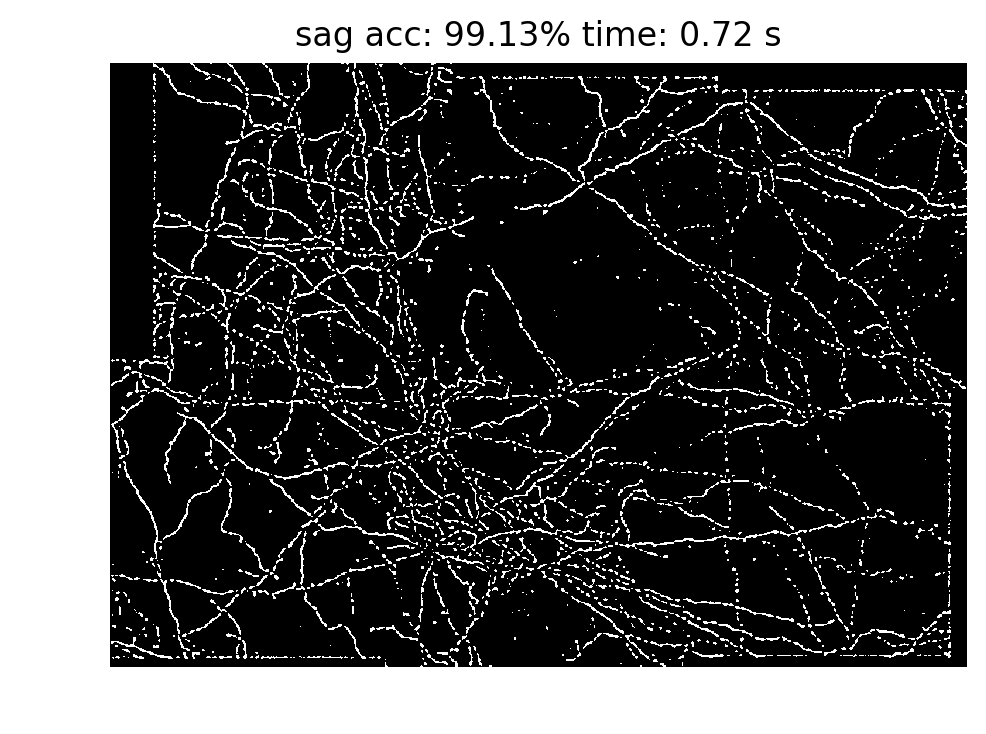

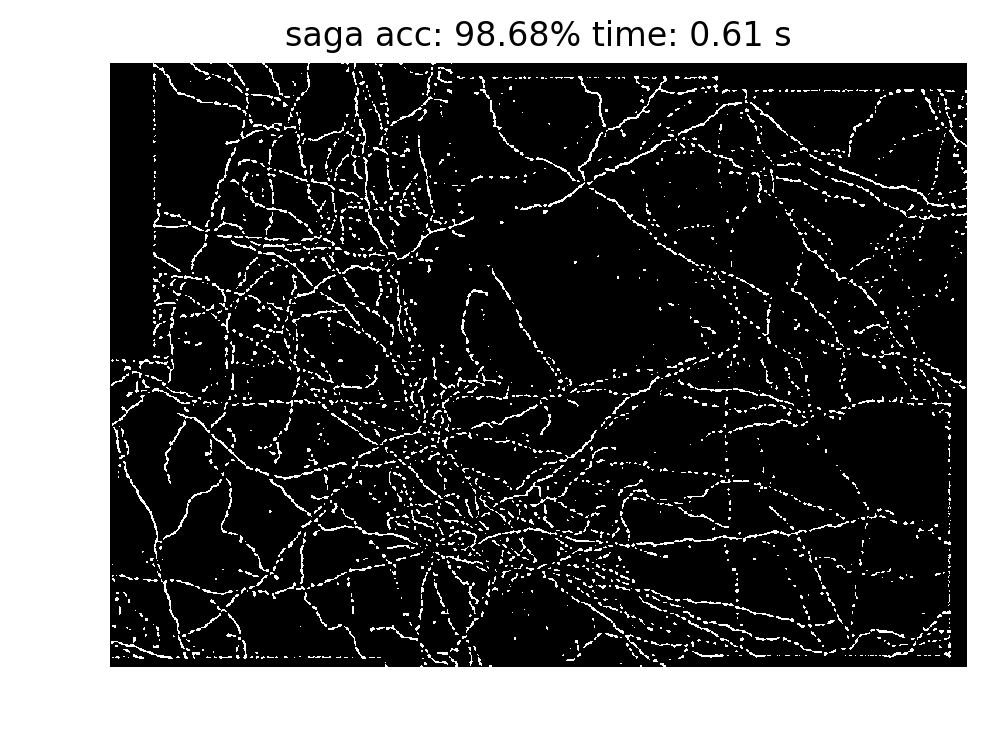

In [19]:
top_filters = sorted_indices[:10]
reduced_train_x = train_x[:, top_filters]

for solver in ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']:
    start = time.time()
    logit_reduced = linear_model.LogisticRegression(penalty='l2',
                                                    tol=0.0001,
                                                    C=1.0,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    solver=solver,
                                                    max_iter=100,
                                                    n_jobs=-1)

    logit_reduced.fit(reduced_train_x, train_y)
    end = time.time()
    acc = logit_reduced.score(reduced_train_x, train_y)
    show_classifier_result(compiled_data[:, :, top_filters], logit_reduced)
    plt.gca().set_title('{} acc: {:.2%} time: {:.2f} s'.format(solver, acc, end-start))

## Cameron (Nearest Neighbor Classifier)

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=25,
                                     weights='uniform', 
                                     algorithm='auto', 
                                     leaf_size=30, 
                                     p=2, 
                                     metric='minkowski', 
                                     metric_params=None, 
                                     n_jobs=1)

knn.fit(train_x, train_y)
knn.score(train_x, train_y)
show_classifier_result(compiled_data, knn)

## Nathan (Radial Basis Function Support Vector Machine)

In [ ]:
svc = svm.SVC(C=1.0,
              kernel='rbf',
              gamma='auto',
              coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=2048,
              class_weight=None,
              verbose=False,
              max_iter=-1,
              decision_function_shape='ovr',
              random_state=None)
              
svc.fit(train_x, train_y)
svc.score(train_x, train_y)
show_classifier_result(compiled_data, svc)

## Sam & Zhimin (Gaussian Process)

In [ ]:
gp = gaussian_process.GaussianProcessClassifier(kernel=None,
                                                optimizer='fmin_l_bfgs_b',
                                                n_restarts_optimizer=0,
                                                max_iter_predict=100,
                                                warm_start=False,
                                                copy_X_train=True,
                                                random_state=None,
                                                multi_class='one_vs_rest',
                                                n_jobs=None)

gp.fit(train_x, train_y)
gp.score(train_x, train_y)
show_classifier_result(compiled_data, gp)

## Sam & Zhimin (Naive Bayes Classifier)

In [ ]:
bayes = naive_bayes.GaussianNB(priors=None, var_smoothing=1e-09)
# bayes = naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
# bayes = naive_bayes.ComplementNB(alpha=1.0, fit_prior=True, class_prior=None, norm=False)

bayes.fit(train_x, train_y)
bayes.score(train_x, train_y)
show_classifier_result(compiled_data, bayes)

## Torin (Decision Tree)

{'criterion': 'entropy', 'max_depth': 23} 0.99438159593


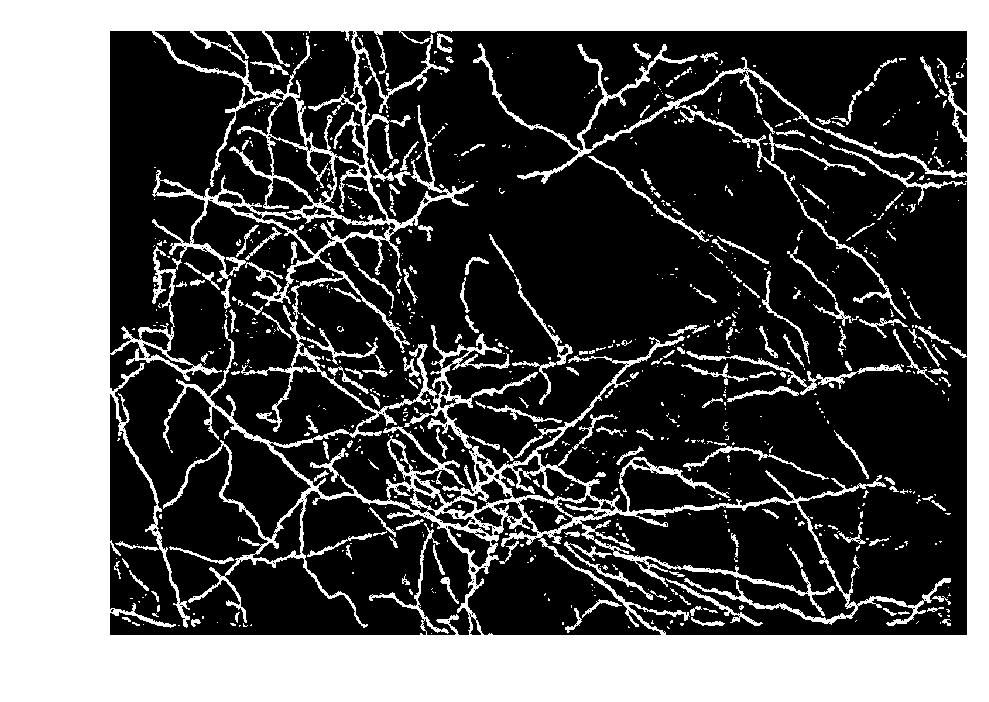

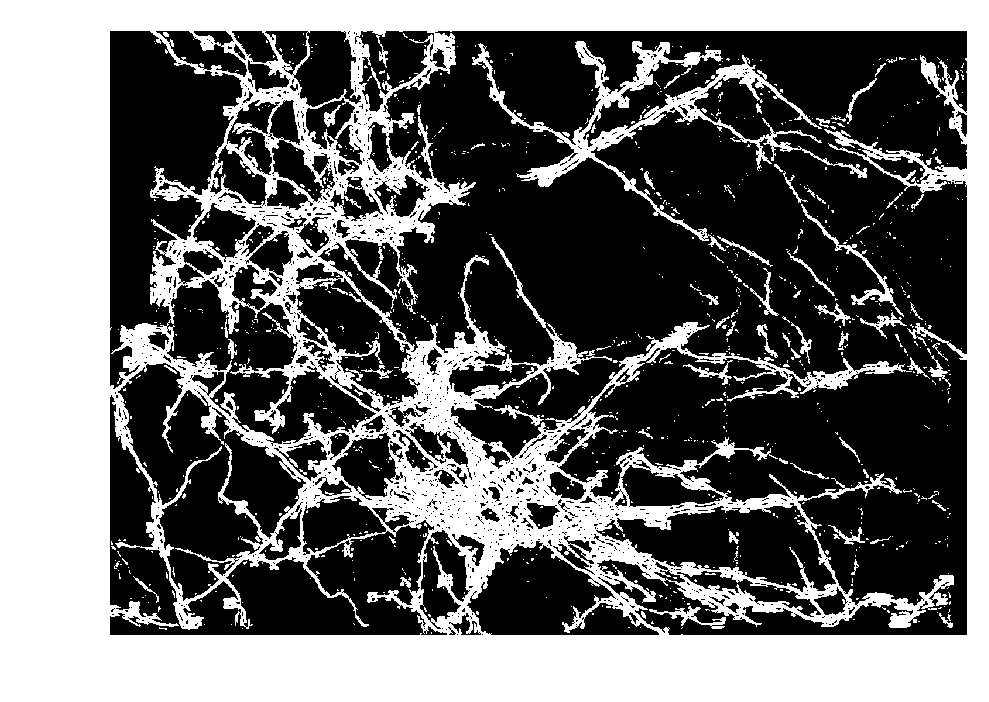

In [37]:
%matplotlib inline  

dt = tree.DecisionTreeClassifier(criterion='gini',
                                 splitter='best',
                                 max_depth=None,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=None,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 class_weight=None,
                                 presort=False)

dt.fit(train_x, train_y)
dt.score(train_x, train_y)


param_grid = {'criterion': ['entropy'],
              'max_depth': [18, 19, 20, 21, 22, 23, 24, 25, None ],
             }

best_dt = model_selection.GridSearchCV(dt, param_grid)
best_dt.fit(train_x, train_y)
print(best_dt.best_params_, best_dt.best_score_)
show_classifier_result(compiled_data, best_dt)
show_classifier_result(compiled_data, dt)


In [35]:
f = open('dt.pk', 'wb')
pickle.dump(dt, f)
f.close()

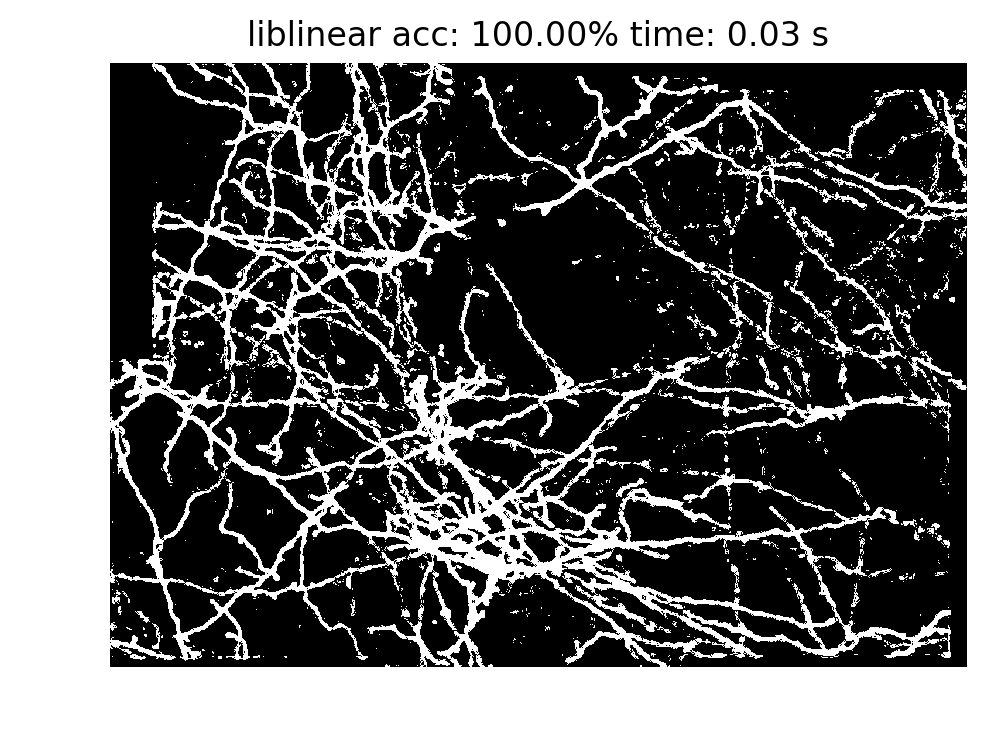

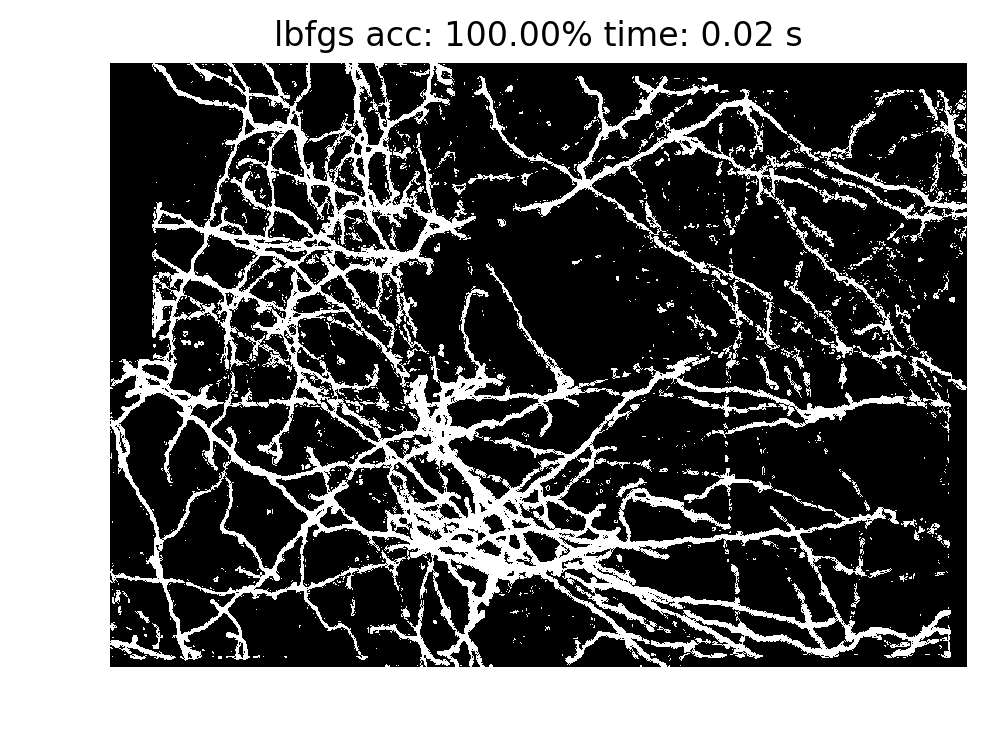

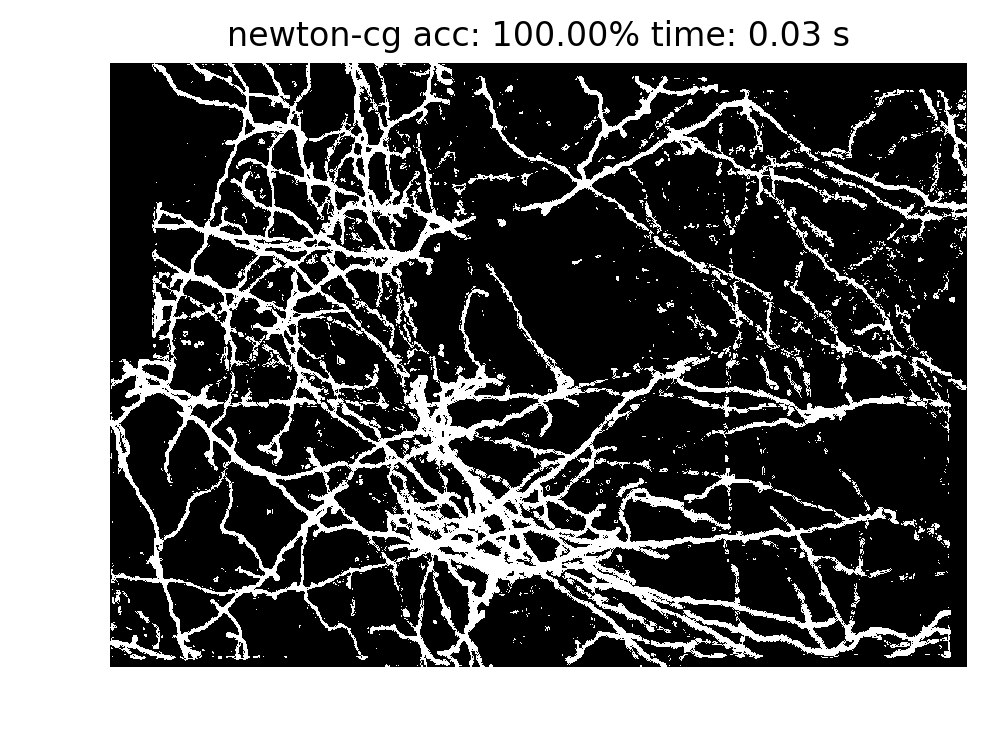

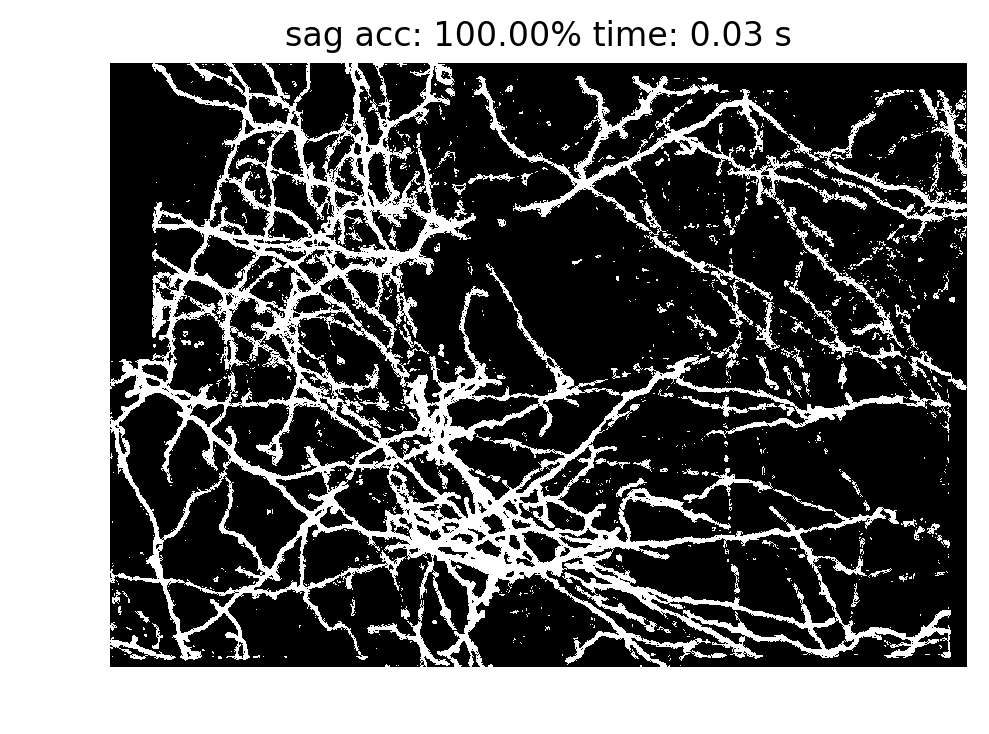

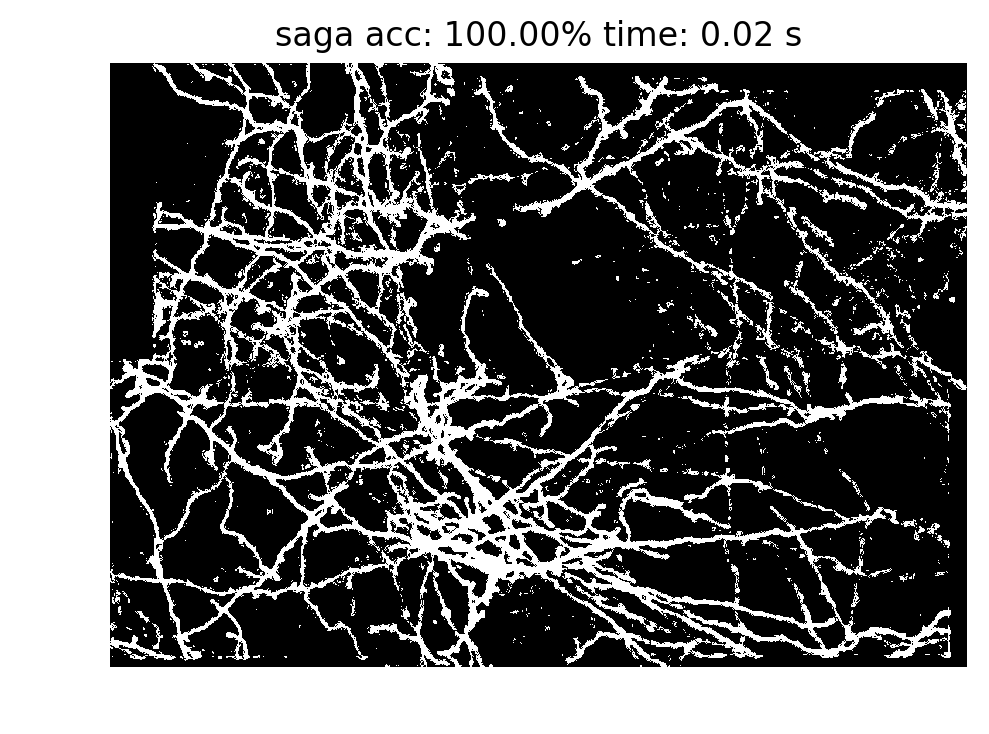

In [68]:
top_filters = sorted_indices[:10]
reduced_train_x = train_x[:, top_filters]

for solver in ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']:
    start = time.time()
    dt_reduced = tree.DecisionTreeClassifier(criterion='entropy',
                                 splitter='best',
                                 max_depth=23,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=None,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 class_weight=None,
                                 presort=False)
    dt_reduced.fit(reduced_train_x, train_y)
    end = time.time()
    acc = dt_reduced.score(reduced_train_x, train_y)
    show_classifier_result(compiled_data[:, :, top_filters], dt_reduced)
    plt.gca().set_title('{} acc: {:.2%} time: {:.2f} s'.format(solver, acc, end-start))

## Di (Random Forest)

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=10,
                                     criterion='gini',
                                     max_depth=None,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features='auto',
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     bootstrap=True,
                                     oob_score=False,
                                     n_jobs=1,
                                     random_state=None,
                                     verbose=0,
                                     warm_start=False,
                                     class_weight=None)


rf.fit(train_x, train_y)
rf.score(train_x, train_y)
show_classifier_result(compiled_data, rf)

## Dan (Adaboost)

In [ ]:
ada = ensemble.AdaBoostClassifier(base_estimator=None,
                                  n_estimators=50,
                                  learning_rate=1.0,
                                  algorithm='SAMME.R',
                                  random_state=None)
ada.fit(train_x, train_y)
ada.score(train_x, train_y)
show_classifier_result(compiled_data, ada)

## TODO

Other Models to try:

* Linear SVM
* Polynomial SVM
* Multilayer Perceptron
* Linear Discriminant Analysis
* Linear Classifiers